In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from envs.mimic import MIMICEnv
from q_networks import D3QNAgent, CQLAgent, FQIAgent

import warnings
warnings.filterwarnings('ignore')

In [65]:
# simple training and eval

def eval_policy(model, env, n_episodes=20, verbose=True):
    """ 
    Custom *online* evaluation for stable baselines policies. 
    
    This is pretty much irrelevant for us considering offline trajectories, but it 
    can give us an idea of what's going on during training, in terms of the terminal 
    reward and length for each episode.
    """

    rewards, lengths = evaluate_policy(model, env, n_eval_episodes=n_episodes, return_episode_rewards=True)

    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title('return / episode')
        ax1.plot(rewards)
        ax2.set_title('episode length')
        ax2.plot(lengths)
        plt.show()

    return np.mean(rewards), np.mean(lengths)


def train_policy(model, env, n_episodes=5000, update_freq=100):
    """ Train a custom-defined policy (D3QN, CQL, FQI, etc.) """

    rewards, lengths = [], []
    
    for epoch in tqdm(range(n_episodes)):
        done = False
        total_reward = 0
        episode_length = 0
        state, _ = env.reset()
        
        while not done:
            action = model.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            model.learn(state, action, reward, next_state, done)
            #print(f'epoch #{epoch}, {done=}, {env.patient.index=}')
            
            done = terminated or truncated
            state = next_state
            total_reward += reward
            episode_length += 1
    
        rewards.append(total_reward)
        lengths.append(episode_length)
    
        if epoch % update_freq == 0:
            d3qn_agent.hard_update()

    return rewards, lengths



def policy_heatmap(env, model_name):
    """
    Visualize the actions selected by a policy, as recorded in the environment's action_log.

    Note that the action_log is a custom feature in MIMICEnv, and that this only works if each
    policy is trained in its own environment instance.
    """
    
    data = env.action_log
    #data[(0,1)] = 100 # this is to verify that my rows and columns are set up properly
    fig, ax = plt.subplots()
    
    sns.heatmap(env.action_log, cmap='crest', annot=True)

    ax.set_title(model_name + ' policy')
    plt.gca().invert_yaxis()
    ax.set_xlabel('vasopressor bin')
    ax.set_ylabel('iv bin')
    ax.grid(which='minor', color='b', linestyle='-', linewidth=1)

    plt.show()


In [59]:
### Proximal Policy Optimization ###

env = MIMICEnv()
rewards, lengths = [], []

for _ in tqdm(range(30)):
    ppo_model = PPO('MlpPolicy', env, verbose=False).learn(total_timesteps=5000)
    #ppo_model.save('models/mimic_ppo')
    
    #ppo_model = PPO.load('models/mimic_ppo')
    
    avg_reward, avg_length = eval_policy(ppo_model, env, n_episodes=100, verbose=False)
    rewards.append(avg_reward)
    lengths.append(avg_length)

100%|███████████████████████████████████████████| 30/30 [01:31<00:00,  3.03s/it]


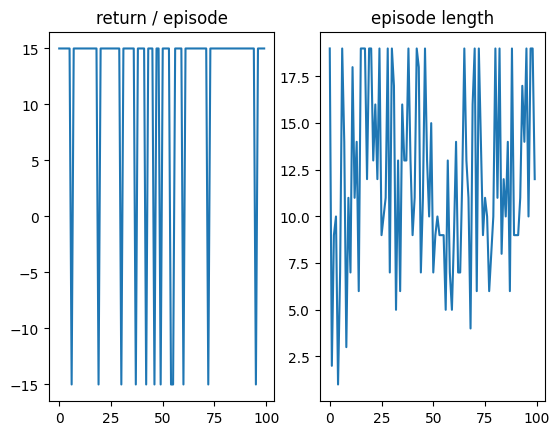

avg reward from ppo: 10.57
avg episode length from ppo: 12.065


In [60]:
eval_policy(ppo_model, env, n_episodes=100, verbose=True)
print(f'avg reward from ppo: {np.mean(rewards)}')
print(f'avg episode length from ppo: {np.mean(lengths)}')

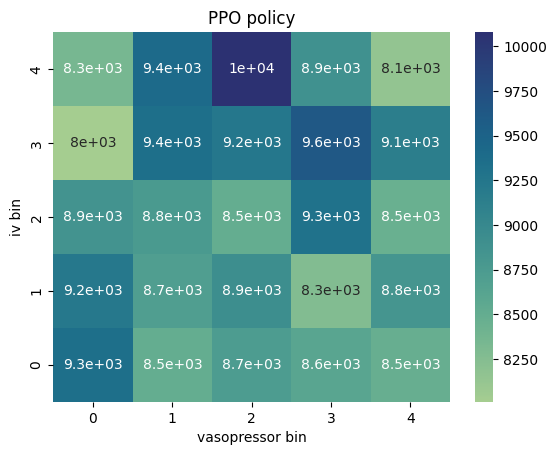

In [66]:
policy_heatmap(env, 'PPO')

100%|███████████████████████████████████████████| 30/30 [01:05<00:00,  2.18s/it]


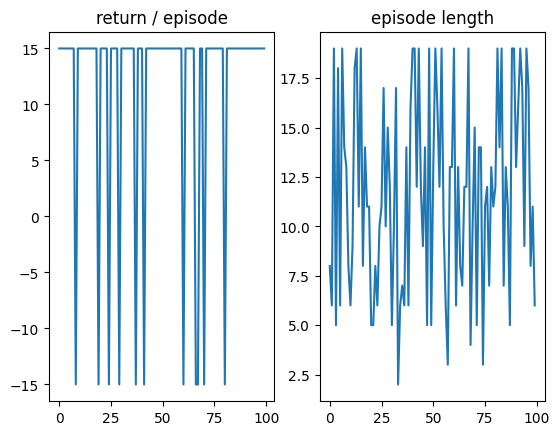

avg reward from dqn: 10.740000000000002
avg episode length from dqn: 12.235666666666667


In [13]:
### Deep Q Networks ###

env = MIMICEnv()
rewards, lengths = [], []

for _ in tqdm(range(30)):

    dqn_model = DQN('MlpPolicy', env, verbose=False).learn(total_timesteps=5000)
    #dqn_model.save('models/mimic_dqn')
    
    #dqn_model = DQN.load('models/mimic_dqn')
    
    avg_reward, avg_length = eval_policy(dqn_model, env, n_episodes=100, verbose=False)
    rewards.append(avg_reward)
    lengths.append(avg_length)

eval_policy(dqn_model, env, n_episodes=100, verbose=True)
print(f'avg reward from dqn: {np.mean(rewards)}')
print(f'avg episode length from dqn: {np.mean(lengths)}')

In [21]:
### Dueling Double Deep Q Networks ###

env = MIMICEnv()
d3qn_agent = D3QNAgent(env.obs_dim, env.action_dim)
d3qn_rewards, d3qn_episode_lengths = train_policy(d3qn_agent, env)

d3qn_train_df = pd.DataFrame({'rewards': d3qn_rewards, 'episode_lengths': d3qn_episode_lengths})

100%|██████████████████████████████████████| 5000/5000 [00:48<00:00, 103.41it/s]


avg reward: 10.734, avg episode length: 12.2096)


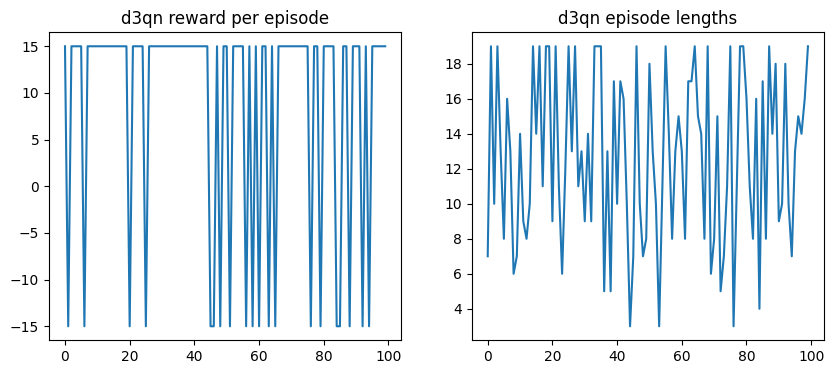

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(d3qn_train_df['rewards'][:100])
axs[0].set_title('d3qn reward per episode')
axs[1].plot(d3qn_train_df['episode_lengths'][:100])
axs[1].set_title('d3qn episode lengths')

print(f'avg reward: {np.mean(d3qn_rewards)}, avg episode length: {np.mean(d3qn_episode_lengths)})')

100%|███████████████████████████████████████| 5000/5000 [00:50<00:00, 98.93it/s]


avg reward: 10.692, avg episode length: 12.1062)


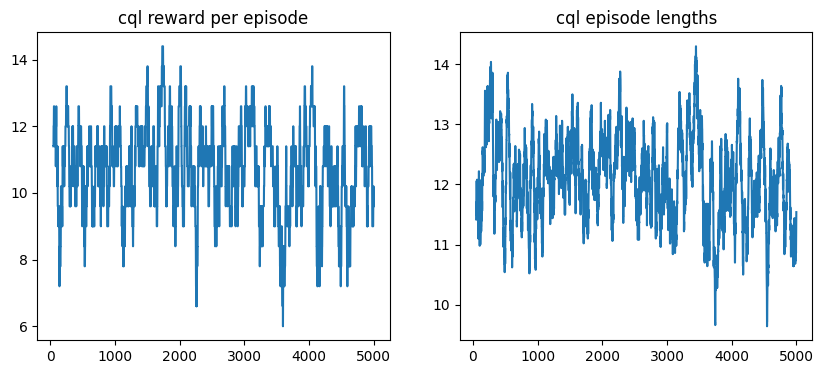

In [14]:
### Conservative Q-Learning (CQL) ###

env = MIMICEnv()
cql_agent = CQLAgent(env.obs_dim, env.action_dim)
cql_rewards, cql_episode_lengths = train_policy(cql_agent, env)

cql_train_df = pd.DataFrame({'rewards': cql_rewards, 'episode_lengths': cql_episode_lengths})

avg reward: 10.692, avg episode length: 12.1062)


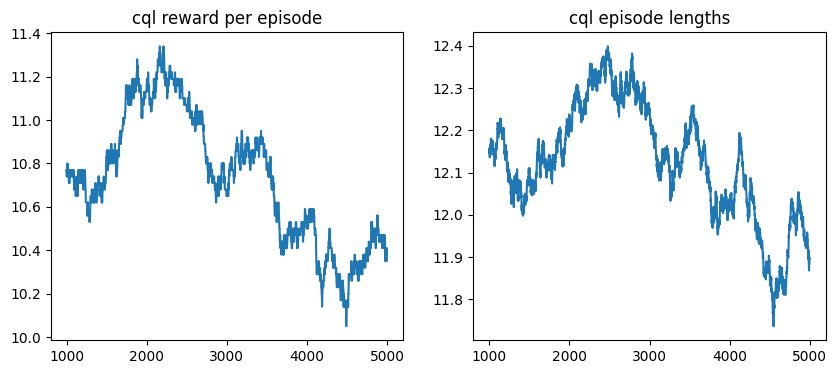

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(cql_train_df['rewards'].rolling(1000).mean())
axs[0].set_title('cql reward per episode')
axs[1].plot(cql_train_df['episode_lengths'].rolling(1000).mean())
axs[1].set_title('cql episode lengths')

print(f'avg reward: {np.mean(cql_rewards)}, avg episode length: {np.mean(cql_episode_lengths)})')

In [67]:
### Clinician Imitation (FQI) ###

env = MIMICEnv()
clinician = FQIAgent(env.obs_dim, env.action_dim)
clin_rewards, clin_episode_lengths = train_policy(clinician, env)

clin_train_df = pd.DataFrame({'rewards': clin_rewards, 'episode_lengths': clin_episode_lengths})


100%|██████████████████████████████████████| 5000/5000 [00:44<00:00, 111.45it/s]


avg reward: 10.59, avg episode length: 12.1886)


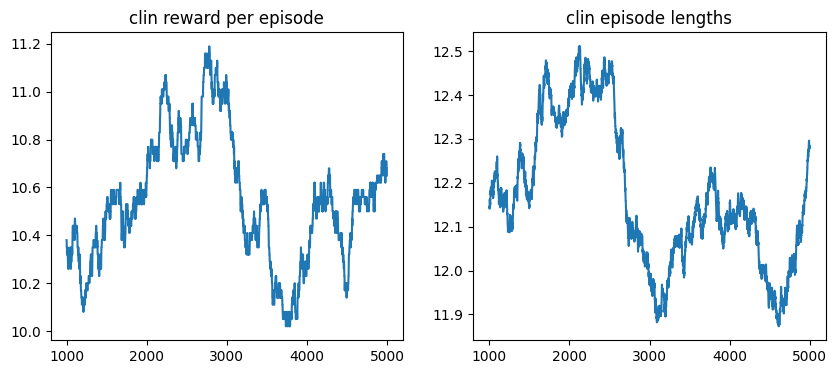

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(clin_train_df['rewards'].rolling(1000).mean())
axs[0].set_title('clin reward per episode')
axs[1].plot(clin_train_df['episode_lengths'].rolling(1000).mean())
axs[1].set_title('clin episode lengths')

print(f'avg reward: {np.mean(clin_rewards)}, avg episode length: {np.mean(clin_episode_lengths)})')

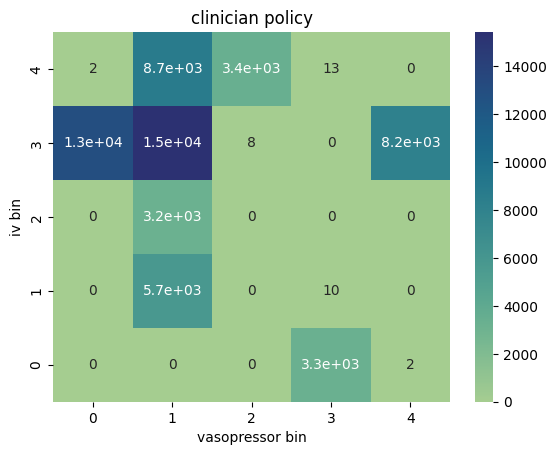

In [69]:
policy_heatmap(env, 'clinician')

In [ ]:
### actual clinician actions ###

